<a href="https://colab.research.google.com/github/2024-MJU-Capstone-Design/coinmerge-ml/blob/feature%2FlearnAI/coin_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.3 MB/s eta 0:00:00


12/12 [==============================] - 0s 3ms/step


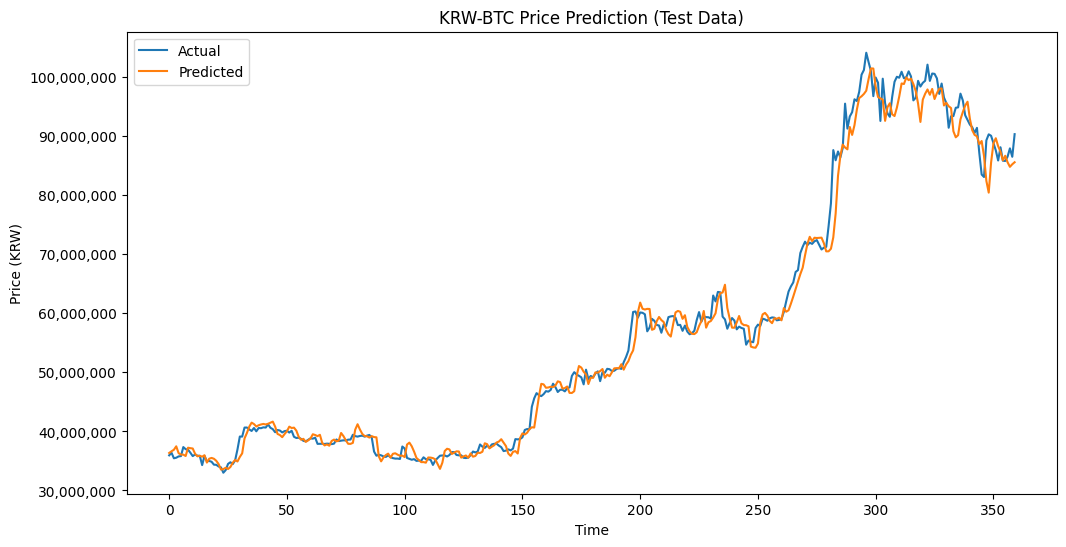

12/12 [==============================] - 0s 2ms/step


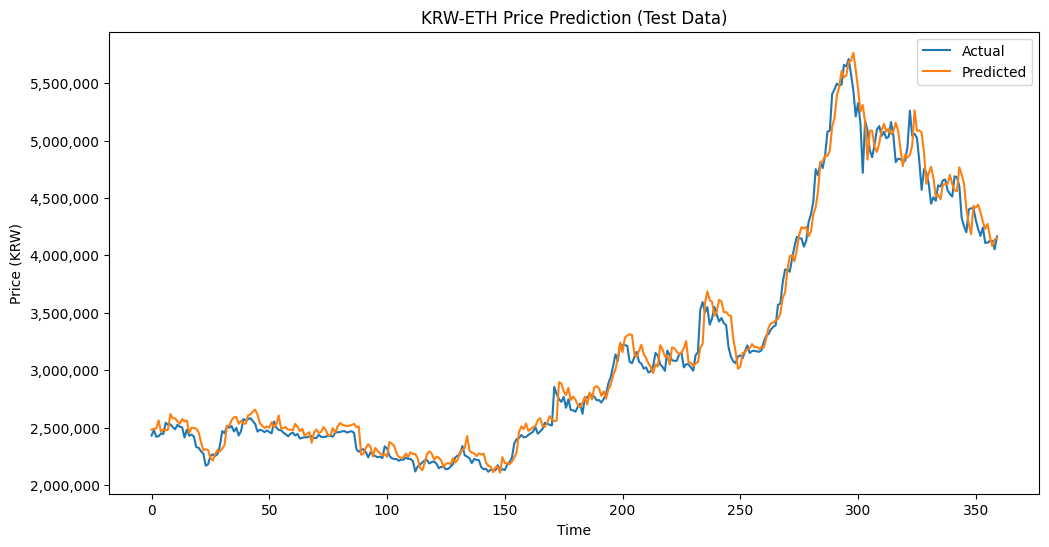

12/12 [==============================] - 0s 2ms/step


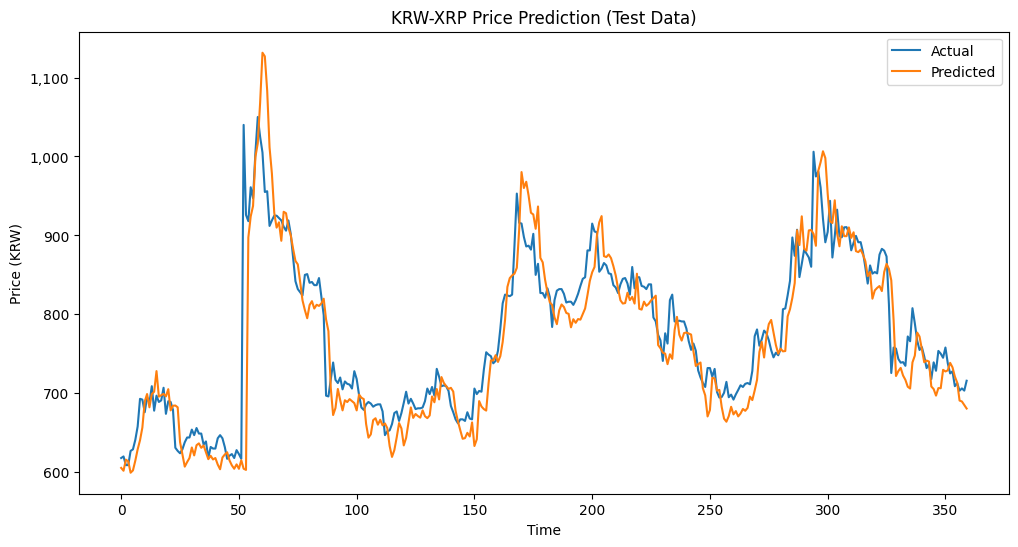

12/12 [==============================] - 0s 2ms/step


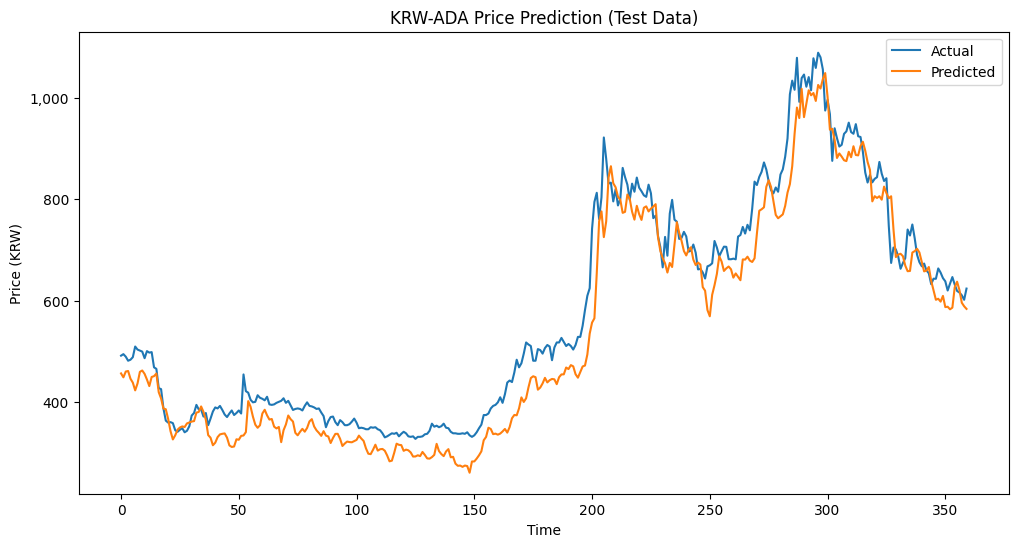

9/9 [==============================] - 1s 3ms/step


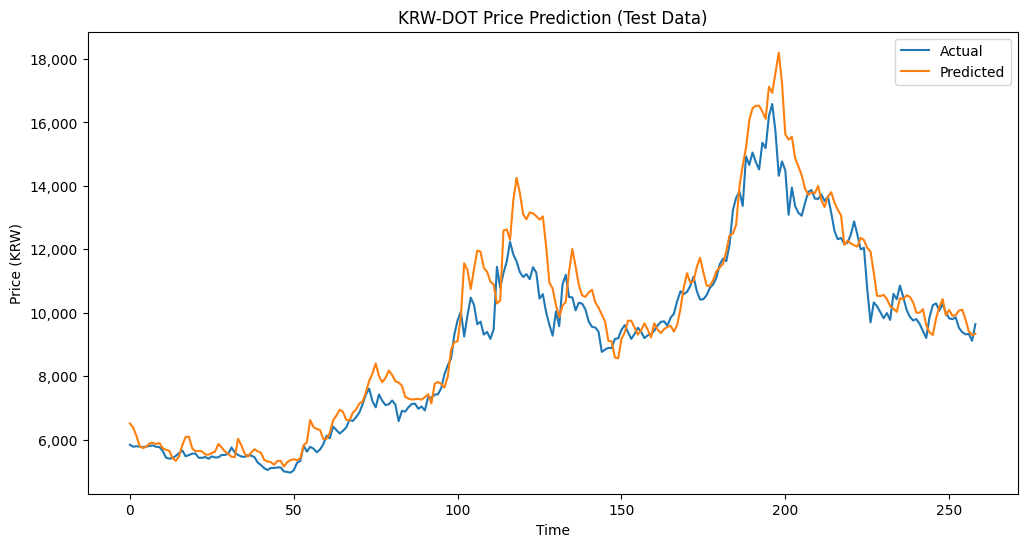

6/6 [==============================] - 0s 3ms/step


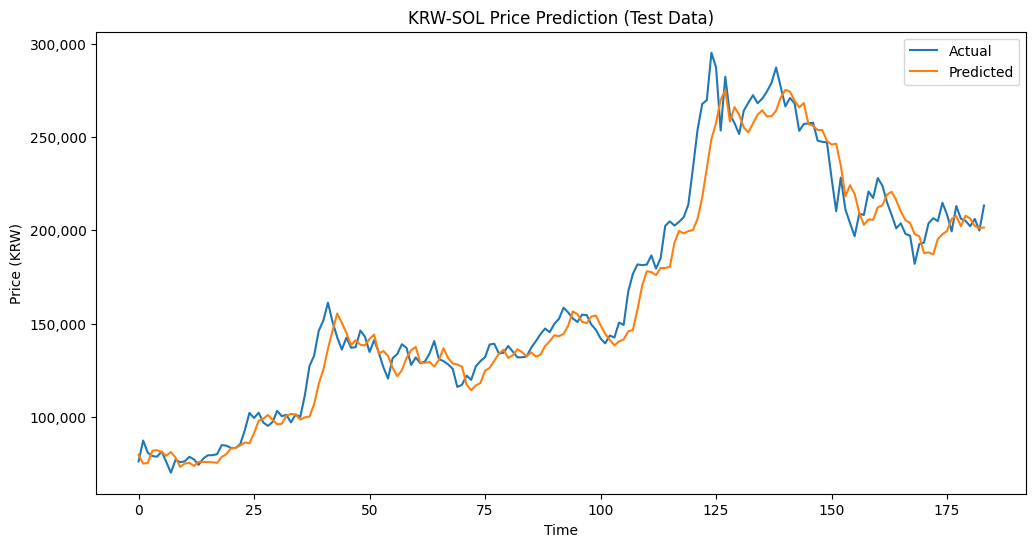

12/12 [==============================] - 0s 3ms/step


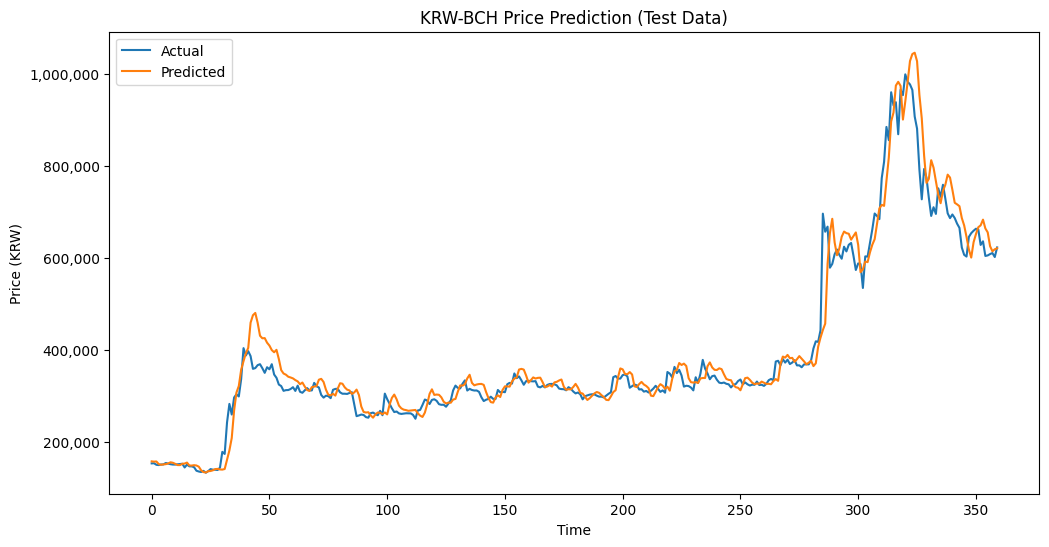

9/9 [==============================] - 0s 3ms/step


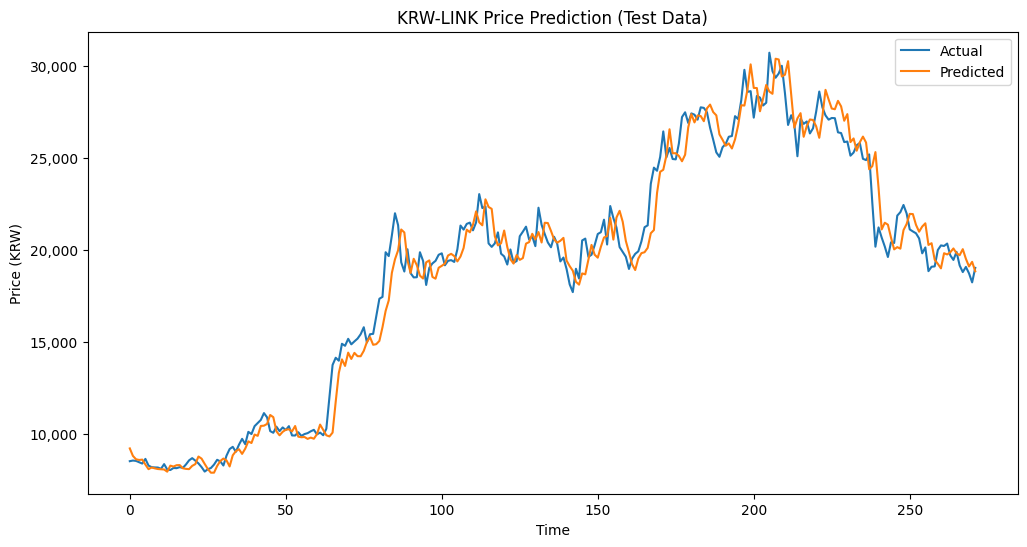

12/12 [==============================] - 0s 3ms/step


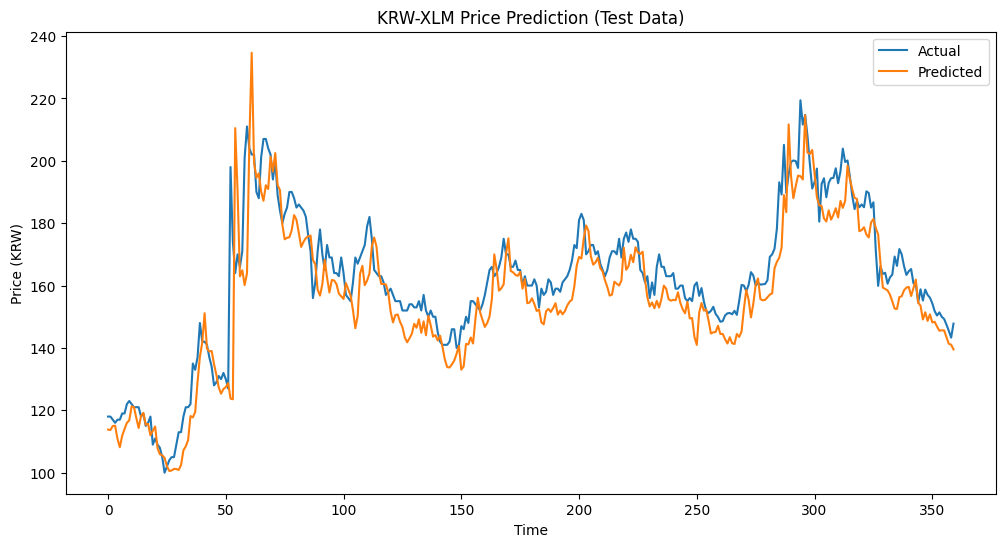

8/8 [==============================] - 0s 3ms/step


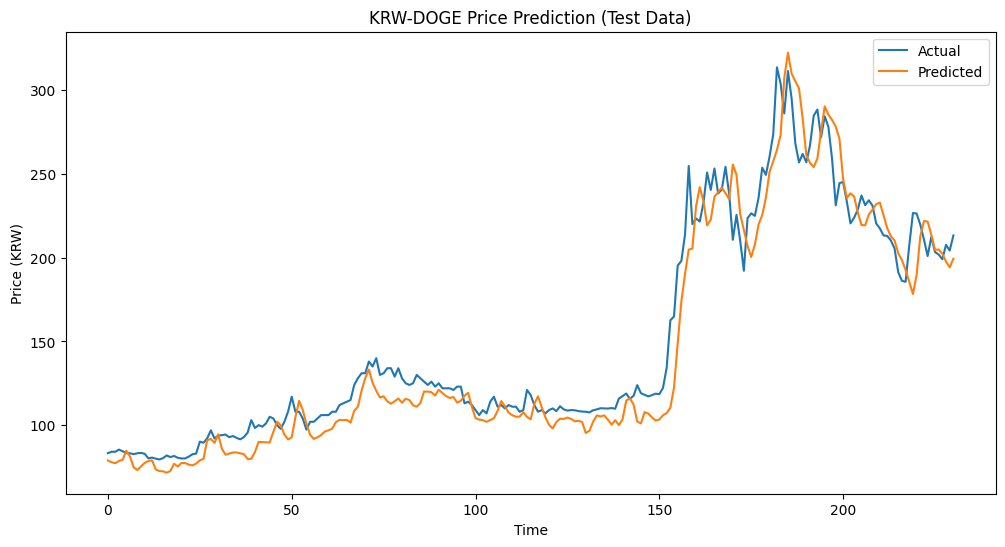

1/1 [==============================] - 0s 19ms/step
암호화폐 가격 예측 결과가 'crypto_predictions.csv' 파일로 저장되었습니다.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pyupbit
from datetime import datetime, timedelta

# 암호화폐 심볼 리스트
symbols = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-ADA", "KRW-DOT", "KRW-SOL", "KRW-BCH", "KRW-LINK", "KRW-XLM", "KRW-DOGE"]

# RSI 계산 함수
def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    avg_gains = gains.rolling(window=window).mean()
    avg_declines = -declines.rolling(window=window).mean()
    rs = avg_gains / avg_declines
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 결과를 저장할 데이터프레임 생성
result_df = pd.DataFrame(columns=['Date'] + symbols)

# 암호화폐별 예측
for symbol in symbols:
    # 데이터 로드
    df = pyupbit.get_ohlcv(symbol, count=365*5)  # 5년치 데이터 로드

    # RSI 계산
    df['RSI'] = calculate_rsi(df)
    df['Target'] = df['close'].shift(-1)  # 다음 날 종가를 Target으로 설정
    df.dropna(inplace=True)

    # 입력 데이터와 타겟 데이터 분리
    X = df[['RSI', 'open', 'high', 'low', 'close', 'volume']].values
    Y = df['Target'].values

    # 데이터 정규화
    scaler = {col: MinMaxScaler() for col in ['RSI', 'open', 'high', 'low', 'close', 'volume']}
    for i, col in enumerate(['RSI', 'open', 'high', 'low', 'close', 'volume']):
        X[:, i] = scaler[col].fit_transform(X[:, i].reshape(-1, 1)).flatten()
    Y = scaler['close'].fit_transform(Y.reshape(-1, 1))

    # 입력 데이터 reshape
    look_back = 10
    X_reshaped = []
    for i in range(len(X) - look_back):
        X_reshaped.append(X[i:i+look_back])
    X_reshaped = np.array(X_reshaped)
    Y_reshaped = Y[look_back:]

    # 훈련셋과 테스트셋 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, shuffle=False)

    # LSTM 모델 구성
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 6)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # 모델 학습
    model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)

    # 테스트셋 예측
    predicted_prices_scaled = model.predict(X_test)
    actual_prices = scaler['close'].inverse_transform(Y_test)
    predicted_prices = scaler['close'].inverse_transform(predicted_prices_scaled)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices, label='Actual')
    plt.plot(predicted_prices, label='Predicted')
    plt.title(f'{symbol} Price Prediction (Test Data)')
    plt.xlabel('Time')
    plt.ylabel('Price (KRW)')
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend()
    plt.show()

    # 내일 가격 예측
    last_data = df.tail(look_back)
    last_data_scaled = np.zeros_like(last_data[['RSI', 'open', 'high', 'low', 'close', 'volume']])

    for i, col in enumerate(['RSI', 'open', 'high', 'low', 'close', 'volume']):
        last_data_scaled[:, i] = scaler[col].transform(last_data[col].values.reshape(-1, 1)).flatten()

    predicted_price_scaled = model.predict(last_data_scaled.reshape(1, look_back, 6))
    predicted_price = scaler['close'].inverse_transform(predicted_price_scaled)[0][0]

    # 전날 대비 상승률 계산
    prev_close = df['close'].iloc[-1]
    change_rate = (predicted_price - prev_close) / prev_close * 100

    # 결과 데이터프레임에 추가
    next_date = datetime.now().date() + timedelta(days=1)
    result_df.loc[0, 'Date'] = next_date.strftime('%Y.%m.%d')
    result_df.loc[0, symbol] = change_rate

# CSV 파일로 저장
result_df.to_csv('crypto_predictions.csv', index=False)
print("암호화폐 가격 예측 결과가 'crypto_predictions.csv' 파일로 저장되었습니다.")